# Project II: Economic Growth 

This notebook will help you getting started with analyzing the growth dataset, `growth.csv`.

In [1]:
import pandas as pd 
import numpy as np 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy.linalg as la

from scipy.stats import norm
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures

## Read data 

In [2]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary
print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


# Descriptive plots

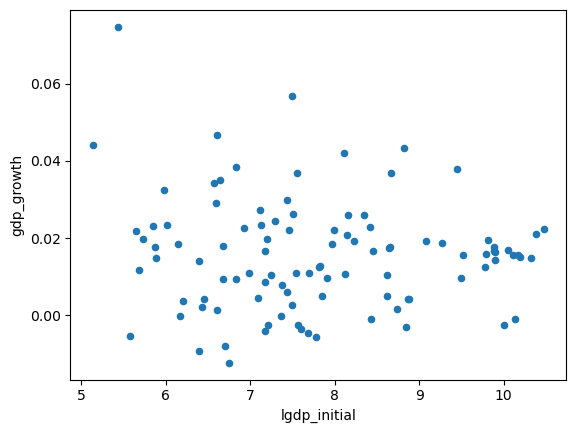

In [3]:
dat.plot.scatter(x='lgdp_initial', y='gdp_growth');

In [4]:
import seaborn as sns 
sns.scatterplot(x='lgdp_initial', y='gdp_growth', data=dat, hue='malfal');

# Collections of variables

In order to make the analysis simpler, it may be convenient to collect variables in sets that belong together naturally. 

In [5]:
# all available variables
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 

vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]

vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage']
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources
         }

list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]


In [6]:
# convenient to keep a column of ones in the dataset
dat['constant'] = np.ones((dat.shape[0],))

In [7]:
alpha = 0.05 # significance level

# OLS

In [8]:
def OLS_func(y,X,logg):

    # Run OLS
    coefs_OLS = la.inv(X.T @ X) @ X.T @ y
    beta_OLS = coefs_OLS[logg][0]

    # Save the residuals 
    res_OLS = y - X @ coefs_OLS

    # Estimate variance
    SSR = res_OLS.T @ res_OLS
    sigma2_OLS = SSR/(X.shape[0] - X.shape[1])
    cov = sigma2_OLS * la.inv(X.T @ X)

    # Calculate standard errors
    se = np.sqrt(np.diag(cov)).reshape(-1,1)

    # Get standard error of beta
    se_OLS = se[logg][0]

    # Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
    q = norm.ppf(1-alpha/2)

    # Calculate confidence interval
    CI_OLS =  (((beta_OLS-q*se_OLS).round(3),(beta_OLS+q*se_OLS).round(3)))

    # Returns beta, standard eroor and confidence interval
    return coefs_OLS, beta_OLS, se_OLS, CI_OLS

## Simple OLS

In [9]:
# Avoiding missings 
I = dat[['gdp_growth', 'lgdp_initial']].notnull().all(axis=1)

# Extract dataset 
y_simple = dat.loc[I, 'gdp_growth'].values.reshape((-1,1)) * 100.0
X = dat.loc[I, ['constant','lgdp_initial']].values

# Extract from OLS function 
coefs_OLS_1, beta_OLS_1, se_OLS_1, CI_OLS_1 = OLS_func(y_simple,X,1)

## Adding more controls

In [10]:
# Control variables
zs = vv_all['geography'] + ['pop_growth', 'investment_rate'] + ['marketref', 'demreg', 'dem']
# Beta 
ds = ['lgdp_initial']
# All variables
xs = ds + zs

# Avoiding missings
all_vars = ['gdp_growth'] + xs
I = dat[all_vars].notnull().all(1)

# Extract data
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100
Z = dat.loc[I, zs].values
D = dat.loc[I, ds].values
X = dat.loc[I, xs].values

# Add const. (unless this breaks the rank condition)
oo = np.ones((I.sum(),1))
XX = np.hstack([X, oo])
xs.append('constant') # we put it in as the last element

# Check the rank condition
K = XX.shape[1]
assert np.linalg.matrix_rank(XX) == XX.shape[1], f'X does not have full rank'

# Extract from OLS function 
coefs_OLS_2, beta_OLS_2, se_OLS_2, CI_OLS_2 = OLS_func(y,XX,0)

In [11]:
print(len(all_vars))

28


# Prepare data for LASSO

## Adding technical variables - interaction

In [12]:
# Add interaction terms 
int = PolynomialFeatures(interaction_only=True, include_bias=False)
Z_int = int.fit_transform(Z)

# Removes all columns which have a std of 0 in order to fulfill the rank condition 
i_idx_int = [i for i in range(Z_int.shape[1]) if np.std(Z_int[:, i]) != 0]
i_idx_2 = [i for i in range(Z_int.shape[1]) if np.std(Z_int[:, i]) == 0]

# Dropping interaction terms without variance
Z_int = Z_int[:,i_idx_int]    

# Define X with new Z 
X_int = np.hstack([D,Z_int])

# Excluded variables
int_names_int = int.get_feature_names_out(zs)
idx_2_int = int_names_int[i_idx_2] 
print(f'Excluded variables = {i_idx_2}')

Excluded variables = [308, 315, 316, 317, 323, 324, 330]


## Adding technical variables - Squared variables

In [13]:
# Add squared terms 
poly = PolynomialFeatures(2, include_bias=False)
Z_poly = poly.fit_transform(Z)

# Remores all columns which have a std of 0 in order to fulfill the rank condition 
i_idx_poly = [i for i in range(Z_poly.shape[1]) if np.std(Z_poly[:, i]) != 0]
i_idx_2 = [i for i in range(Z_poly.shape[1]) if np.std(Z_poly[:, i]) == 0]

# Dropping terms with out variance
Z_poly = Z_poly[:,i_idx_poly]     

# Define X with new Z
X_poly = np.hstack([D,Z_poly])

# Interaction terms for dummies at then excluded 
int_names_poly = poly.get_feature_names_out(zs)
idx_2_poly = int_names_poly[i_idx_2] 
print(f'Excluded variables = {idx_2_poly}')

Excluded variables = ['landlock oceania' 'africa asia' 'africa oceania' 'africa americas'
 'asia oceania' 'asia americas' 'oceania americas']


# LASSO

## Standardize data

In [14]:
# Define standardize function 
def standardize(X):
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X_stan = (X - X_mean)/X_std
    return X_stan

# Standardize all
X_stan = standardize(X)
Z_stan = standardize(Z)
D_stan = standardize(D)
Z_int_stan = standardize(Z_int)
X_int_stan = standardize(X_int)
Z_poly_stan = standardize(Z_poly)
X_poly_stan = standardize(X_poly)

## Function to define penalty term 

In [15]:
# Make a function that calculates BRT
def BRT(X_tilde,y):

    # Setup variables
    n,p = X_tilde.shape
    sigma = np.std(y, ddof=1)
    c = 1.1
    alpha = 0.05
    max_term = 1  

    # Calculate penalty
    penalty_BRT = c*sigma*norm.ppf(1-alpha/(2*p))/np.sqrt(n*max_term)

    return penalty_BRT

# Make a function that calculates BCCH
def BCCH(X_tilde,y):
    
    # Setup variables 
    n,p = X_tilde.shape
    c = 1.1
    alpha = 0.05

    # Pilot penalty
    yXscale = (np.max((X_tilde.T ** 2) @ ((y-np.mean(y)) ** 2) / n)) ** 0.5
    penalty_pilot = c / np.sqrt(n) * norm.ppf(1-alpha/(2*p)) * yXscale # Note: Have divided by 2 due to Python definition of Lasso

    # Pilot estimates
    coef_pilot = Lasso(alpha=penalty_pilot, max_iter=10_000).fit(X_tilde,y).coef_
    coef_intercept = Lasso(alpha=penalty_pilot, max_iter=10_000).fit(X_tilde,y).intercept_
    pred = (coef_intercept + X_tilde@coef_pilot)

    # Updated penalty
    eps = y - pred 
    epsXscale = (np.max((X_tilde.T ** 2) @ (eps ** 2) / n)) ** 0.5
    penalty_BCCH = c*norm.ppf(1-alpha/(2*p))*epsXscale/np.sqrt(n)

    return penalty_BCCH

## Post Double Lasso

### Step 1: Lasso Y using D and Z

In [16]:
# Calculating penalty terms
penalty_BRTyx = BRT(X_stan,y)
penalty_BCCHyx = BCCH(X_stan,y)
penalty_BRTyx_1 = BRT(X_int_stan,y)
penalty_BCCHyx_1 = BCCH(X_int_stan,y)
penalty_BRTyx_2 = BRT(X_poly_stan,y)
penalty_BCCHyx_2 = BCCH(X_poly_stan,y)

# Lasso on gqp growth
fit_BRTyx = Lasso(alpha=penalty_BRTyx, max_iter=10_000).fit(X_stan,y) 
fit_BCCHyx = Lasso(alpha=penalty_BCCHyx, max_iter=10_000).fit(X_stan,y) 
fit_BRTyx_1 = Lasso(alpha=penalty_BRTyx_1, max_iter=10_000).fit(X_int_stan,y) 
fit_BCCHyx_1 = Lasso(alpha=penalty_BCCHyx_1, max_iter=10_000).fit(X_int_stan,y) 
fit_BRTyx_2 = Lasso(alpha=penalty_BRTyx_2, max_iter=10_000).fit(X_poly_stan,y) 
fit_BCCHyx_2 = Lasso(alpha=penalty_BCCHyx_2, max_iter=10_000).fit(X_poly_stan,y) 

# Lasso coefficients
coefs = fit_BRTyx.coef_
coefs_BCCH = fit_BCCHyx.coef_
coefs_1 = fit_BRTyx_1.coef_
coefs_BCCH_1 = fit_BCCHyx_1.coef_
coefs_2 = fit_BRTyx_2.coef_
coefs_BCCH_2 = fit_BCCHyx_2.coef_

# Save residuals
resyx = y - fit_BRTyx.predict(X_stan) 
resyx_BCCH = y - fit_BCCHyx.predict(X_stan)
resyx_1 = y - fit_BRTyx_1.predict(X_int_stan)
resyx_BCCH_1 = y - fit_BCCHyx_1.predict(X_int_stan)
resyx_2 = y - fit_BRTyx_2.predict(X_poly_stan)
resyx_BCCH_2 = y - fit_BCCHyx_2.predict(X_poly_stan)

# Save residuals
resyxz = resyx + D_stan * coefs[0]
resyxz_BCCH = resyx_BCCH + D_stan * coefs_BCCH[0]
resyxz_1 = resyx_1 + D_stan * coefs_1[0]
resyxz_BCCH_1 = resyx_BCCH_1 + D_stan * coefs_BCCH_1[0]
resyxz_2 = resyx_2 + D_stan * coefs_2[0]
resyxz_BCCH_2 = resyx_BCCH_2 + D_stan * coefs_BCCH_2[0]

### Step 2: Lasso D using Z

In [17]:
# Calculating penalty terms
penalty_BRTdz = BRT(Z_stan, D)
penalty_BCCHdz = BCCH(Z_stan, D)
penalty_BRTdz_1 = BRT(Z_int_stan, D)
penalty_BCCHdz_1 = BCCH(Z_int_stan, D)
penalty_BRTdz_2 = BRT(Z_poly_stan, D)
penalty_BCCHdz_2 = BCCH(Z_poly_stan, D)

# Lasso on initial gdp
fit_BRTdz = Lasso(alpha = penalty_BRTdz).fit(Z_stan,D) 
fit_BCCHdz = Lasso(alpha = penalty_BCCHdz).fit(Z_stan,D)
fit_BRTdz_1 = Lasso(alpha = penalty_BRTdz_1).fit(Z_int_stan,D) 
fit_BCCHdz_1 = Lasso(alpha = penalty_BCCHdz_1).fit(Z_int_stan,D)
fit_BRTdz_2 = Lasso(alpha = penalty_BRTdz_2).fit(Z_poly_stan,D) 
fit_BCCHdz_2 = Lasso(alpha = penalty_BCCHdz_2).fit(Z_poly_stan,D)

# Save residuals
resdz = D - fit_BRTdz.predict(Z_stan)
resdz_BCCH = D - fit_BCCHdz.predict(Z_stan)
resdz_1 = D - fit_BRTdz_1.predict(Z_int_stan)
resdz_BCCH_1 = D - fit_BCCHdz_1.predict(Z_int_stan)
resdz_2 = D - fit_BRTdz_2.predict(Z_poly_stan)
resdz_BCCH_2 = D - fit_BCCHdz_2.predict(Z_poly_stan)

### Step 3: Estimate $\beta$

In [18]:
# Define function that calculates beta
def beta_PDL_func(resdz,resyxz,d):
    num = np.sum(resdz*resyxz)
    denom = np.sum(resdz*d)
    beta_PDL = num/denom
    return beta_PDL

In [19]:
# Estimating Post Double Lasso
beta_PDL = beta_PDL_func(resdz, resyxz, D)
beta_PDL_BCCH = beta_PDL_func(resdz_BCCH, resyxz_BCCH, D)
beta_PDL_1 = beta_PDL_func(resdz_1, resyxz_1, D)
beta_PDL_BCCH_1 = beta_PDL_func(resdz_BCCH_1, resyxz_BCCH_1, D)
beta_PDL_2 = beta_PDL_func(resdz_2, resyxz_2, D)
beta_PDL_BCCH_2 = beta_PDL_func(resdz_BCCH_2, resyxz_BCCH_2, D)

### Step 4: Calculate standard errors and confidence interval for $\beta$

In [20]:
def beta_PDL_CI_func(alpha_PDL,resdz,resyx):
    # Variance

    N = resyx.shape[0]
    num = np.sum(resyx**2 * resdz**2) / N
    denom = (np.sum(resdz**2) / N)**2
    sigma2_PDL = num/denom

    # Confidence interval
    q = norm.ppf(1-alpha/2)
    se_PDL = np.sqrt(sigma2_PDL) / np.sqrt(N)    # calculating standard error as the squareroot of the mean variance
    CI_PDL=(((alpha_PDL-q*se_PDL).round(3),(alpha_PDL+q*se_PDL).round(3)))

    return se_PDL, CI_PDL

# estimating standard errors and confidence interval for Post Double Lasso
se_PDL, CI_PDL = beta_PDL_CI_func(beta_PDL, resdz, resyxz)
se_PDL_BCCH, CI_PDL_BCCH = beta_PDL_CI_func(beta_PDL_BCCH, resdz_BCCH, resyxz_BCCH)
se_PDL_1, CI_PDL_1 = beta_PDL_CI_func(beta_PDL_1, resdz_1, resyxz_1)
se_PDL_BCCH_1, CI_PDL_BCCH_1 = beta_PDL_CI_func(beta_PDL_BCCH_1, resdz_BCCH_1, resyxz_BCCH_1)
se_PDL_2, CI_PDL_2 = beta_PDL_CI_func(beta_PDL_2, resdz_2, resyxz_2)
se_PDL_BCCH_2, CI_PDL_BCCH_2 = beta_PDL_CI_func(beta_PDL_BCCH_2, resdz_BCCH_2, resyxz_BCCH_2)

In [21]:
# Look at the coefficients which are non-zero

# First PDL 
zero_indices = [i for i, value in enumerate(coefs) if value != 0]
names = (xs[zero_indices[0]], xs[zero_indices[1]])
print(names)

# Second PDL 
zero_indices = [i for i, value in enumerate(coefs_1) if value != 0]
names = (int_names_int[zero_indices[0]])
print(names)

# Thord PDL 
zero_indices = [i for i, value in enumerate(coefs_2) if value != 0]
names = int_names_poly[zero_indices[0]]
print(names)

('africa', 'asia')
cenlong oceania
cenlong oceania


## Results

In [22]:
# Estimates
estimates = np.array([beta_OLS_1, beta_OLS_2, beta_PDL, beta_PDL_1, beta_PDL_2, beta_PDL_BCCH, beta_PDL_BCCH_1, beta_PDL_BCCH_2]).round(3)
# Standard errors
se = np.array([se_OLS_1, se_OLS_2, se_PDL, se_PDL_1, se_PDL_2, se_PDL_BCCH, se_PDL_BCCH_1, se_PDL_BCCH_2]).round(3)
# Number of controls
no_controls = np.array([len(coefs_OLS_1)-2, len(coefs_OLS_2)-2, len(coefs)-1, len(i_idx_int),  len(i_idx_poly), len(coefs_BCCH)-1,len(i_idx_int),len(i_idx_poly)])
# Number of controls after penalty
no_controls_penalty = np.array([len(coefs_OLS_1[coefs_OLS_1 != 0])-1, len(coefs_OLS_2[coefs_OLS_2 != 0])-1, len(coefs[coefs != 0]), len(coefs_1[coefs_1 != 0]),  len(coefs_2[coefs_2 != 0]), len(coefs_BCCH[coefs_BCCH != 0]),len(coefs_BCCH_1[coefs_BCCH_1 != 0]),len(coefs_BCCH_2[coefs_BCCH_2 != 0])])
# Number of countries 
no_obs = np.array([len(y_simple), len(y), len(y), len(y), len(y), len(y), len(y), len(y)])
# Penalty dz
pens_dz = np.array(['', '',  penalty_BRTdz.round(3), penalty_BRTdz_1.round(3), penalty_BRTdz_2.round(3), penalty_BCCHdz.round(3), penalty_BCCHdz_1.round(3), penalty_BCCHdz_2.round(3)])
# Penalty yx
pens_yx = np.array(['', '', penalty_BRTyx.round(3), penalty_BRTyx_1.round(3), penalty_BRTyx_2.round(3), penalty_BCCHyx.round(3), penalty_BCCHyx_1.round(3), penalty_BCCHyx_2.round(3)])
# Lower confidence interval
CI_low = np.array([CI_OLS_1[0], CI_OLS_2[0], CI_PDL[0], CI_PDL_1[0], CI_PDL_2[0], CI_PDL_BCCH[0], CI_PDL_BCCH_1[0], CI_PDL_BCCH_2[0]])
# Upper confidence interval
CI_high = np.array([CI_OLS_1[1], CI_OLS_2[1], CI_PDL[1], CI_PDL_1[1], CI_PDL_2[1], CI_PDL_BCCH[1], CI_PDL_BCCH_1[1], CI_PDL_BCCH_2[1]])
# t-statistic
t_statistic = (estimates/se).round(3)  

# Column and row labels
label_over_column = ['(1)','(2)','(3)','(4)','(5)','(6)','(7)','(8)']
label_column = np.array(['OLS', 'OLS', 'PDL', 'PDL', 'PDL', 'PDL', 'PDL', 'PDL'])
label_row = ['' ,'Initial $\log{(gdp)}$', 'Standard Error','$\lambda^{dz}$','$\lambda^{yx}$','CI low', 'CI high', 't-statistic', 'No. obs','No. controls', 'No. controls after penalty']

# Create dataframe with all variabes
data = np.row_stack((label_column ,estimates, se, pens_dz, pens_yx, CI_low, CI_high, t_statistic,no_obs,no_controls,no_controls_penalty))

# Create dataframe with labels 
df = pd.DataFrame(data = data, index = label_row, columns = label_over_column)

# Print the table in latex format
print(df.to_latex(escape = False))

\begin{tabular}{lllllllll}
\toprule
 & (1) & (2) & (3) & (4) & (5) & (6) & (7) & (8) \\
\midrule
 & OLS & OLS & PDL & PDL & PDL & PDL & PDL & PDL \\
Initial $\log{(gdp)}$ & -0.087 & -1.203 & -0.131 & -0.137 & -0.137 & -0.132 & -0.132 & -0.132 \\
Standard Error & 0.106 & 0.183 & 0.015 & 0.015 & 0.015 & 0.016 & 0.016 & 0.016 \\
$\lambda^{dz}$ &  &  & 0.549 & 0.672 & 0.675 & 0.916 & 1.11 & 1.115 \\
$\lambda^{yx}$ &  &  & 0.568 & 0.693 & 0.696 & 1.18 & 2.582 & 2.594 \\
CI low & -0.295 & -1.561 & -0.16 & -0.167 & -0.167 & -0.163 & -0.163 & -0.163 \\
CI high & 0.121 & -0.845 & -0.102 & -0.108 & -0.107 & -0.102 & -0.102 & -0.102 \\
t-statistic & -0.821 & -6.574 & -8.733 & -9.133 & -9.133 & -8.25 & -8.25 & -8.25 \\
No. obs & 102 & 76 & 76 & 76 & 76 & 76 & 76 & 76 \\
No. controls & 0 & 26 & 26 & 344 & 370 & 26 & 344 & 370 \\
No. controls after penalty & 1 & 27 & 2 & 1 & 1 & 0 & 0 & 0 \\
\bottomrule
\end{tabular}



In [23]:
# Create a DataFrame
df = pd.DataFrame(lbldf)

# List of values to match
values_to_match = all_vars

# Filter rows where 'Column1' matches values in the list
filtered_df = df[df.index.isin(values_to_match)].reset_index()
filtered_df_1 = filtered_df.drop_duplicates(subset=['variable'])

# Print the filtered DataFrame
print(pd.DataFrame(filtered_df_1).to_latex(escape = False, index=False))

\begin{tabular}{lll}
\toprule
variable & label & source \\
\midrule
dem & Democracy measure by ANRR & ANRR \\
demreg & Average democracy in the region*initial regime (leaving own country out) & ANRR \\
marketref & Index of market reforms (1960) & ANRR \\
distcr & mean distance to coast or river & ANRR \\
distc & mean distance to coast & ANRR \\
distr & mean distance to river & ANRR \\
tropicar & % land area in geographical tropics & ANRR \\
africa & dummy=1 for Africa & AR \\
asia & dummy=1 for Asia & AR \\
landlock & =1 if landlocked & AR \\
cenlong & Geodesic centroid longitude & QG \\
area & Total land area & QG \\
area_ar & Arable land area & QG \\
abslat & Absolute latitude & QG \\
suitavg & Land suitability for agriculture & QG \\
suitgini & Land suitability Gini & QG \\
elevavg & Mean elevation & QG \\
elevstd & Standard deviation of elevation & QG \\
rough & Terrain roughness & QG \\
temp & Temperature & QG \\
precip & Precipitation & QG \\
kgatr & Percentage of population livi